**Install Mido Module**

In [2]:
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


**Import Libraries**

In [23]:
import os
import glob
from mido import MidiFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.sparse import issparse
from keras.models import load_model
from mido import MidiFile, MidiTrack, Message

**Upload File**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving albeniz.zip to albeniz.zip


**Unzip the File**

In [5]:
import zipfile

# Path to the uploaded ZIP file (adjust the filename accordingly)
zip_file_path = '/content/albeniz.zip'

# Create a directory to extract the contents
extract_dir = 'midi_files'
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

**Finding Midi Files in Main Folder**

In [6]:
# Path to the main folder containing subfolders with MIDI files
main_folder_path = extract_dir

# Find all .mid files in subdirectories of the main folder
midi_files = glob.glob(os.path.join(main_folder_path, '**', '*.mid'), recursive=True)

# Check if any files were found
if not midi_files:
    print("No MIDI files found in the directory.")
else:
    print(f"Found {len(midi_files)} MIDI files.")

Found 14 MIDI files.


**Loading File Path**

In [7]:
# Load each MIDI file
for file_path in midi_files:
        # Load the MIDI file
        midi = MidiFile(file_path)
        print(f"Loaded {file_path}")

Loaded midi_files/alb_se2.mid
Loaded midi_files/alb_esp3.mid
Loaded midi_files/alb_se5.mid
Loaded midi_files/alb_esp2.mid
Loaded midi_files/alb_se1.mid
Loaded midi_files/alb_se4.mid
Loaded midi_files/alb_se3.mid
Loaded midi_files/alb_esp4.mid
Loaded midi_files/alb_se6.mid
Loaded midi_files/alb_esp1.mid
Loaded midi_files/alb_se8.mid
Loaded midi_files/alb_esp6.mid
Loaded midi_files/alb_esp5.mid
Loaded midi_files/alb_se7.mid


**Finding Type, Note, Velocity & Time of Midi Files**

In [8]:
note_data = []  # List to store extracted note information

for file_path in midi_files:
    try:
        midi = MidiFile(file_path)
        for i, track in enumerate(midi.tracks):
            for msg in track:
                if msg.type in ['note_on', 'note_off']:
                    note_data.append({
                        'file': file_path,
                        'track': i,
                        'type': msg.type,
                        'note': msg.note,
                        'velocity': msg.velocity,
                        'time': msg.time
                    })
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print(f"Extracted note data from {len(midi_files)} MIDI files.")

Extracted note data from 14 MIDI files.


**Normalization & Quantization of Values**

In [9]:
# Example quantization step size
quantization_step = 0.01

# Normalize and quantize note data
for event in note_data:
    event['normalized_note'] = event['note'] / 127  # Normalizing note value
    event['normalized_velocity'] = event['velocity'] / 127  # Normalizing velocity
    event['quantized_time'] = round(event['time'] * quantization_step)  # Quantizing time

print("Normalization and quantization complete.")

Normalization and quantization complete.


**Creating Input & Output Pairs of Sequence**

In [10]:
sequence_length = 50
input_sequences = []
output_notes = []

for i in range(len(note_data) - sequence_length):
    input_seq = note_data[i:i + sequence_length]
    output_note = note_data[i + sequence_length]['note']

    input_sequences.append(input_seq)
    output_notes.append(output_note)

print(f"Created {len(input_sequences)} input-output pairs.")

Created 51018 input-output pairs.


**Encoding**

In [27]:
note_encoder = OneHotEncoder()

input_notes = [event['note'] for sequence in input_sequences for event in sequence]
input_notes_encoded = note_encoder.fit_transform(np.array(input_notes).reshape(-1, 1))

print("Encoding complete.")

Encoding complete.


**Model Setup**

In [28]:
# Parameters
sequence_length = 50  # Length of input sequences
n_notes = 128  # Number of possible note values (MIDI range)
n_features = 1  # Number of features (e.g., note value)

# Reshape input for LSTM
X = np.array([np.array([note['note'] for note in seq]) for seq in input_sequences])
X = X.reshape((X.shape[0], sequence_length, n_features))

# One-hot encode the output notes
note_encoder = OneHotEncoder(sparse_output=False, categories=[range(n_notes)])
y = note_encoder.fit_transform(np.array(output_notes).reshape(-1, 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(sequence_length, n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(n_notes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,400 (3.14 MB)

 Trainable params: 822,400 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

**Training Model**

In [15]:
# Define file path to save the best model
model_file_path = 'Model.keras'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_file_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Define the EarlyStopping callback (optional)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])
# Summary of the training process
print("Training completed.")

Epoch 1/100
636/638 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1686
Epoch 1: val_loss improved from inf to 3.28102, saving model to Model.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 2.1686 - val_loss: 3.2810
Epoch 2/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0978
Epoch 2: val_loss improved from 3.28102 to 3.27610, saving model to Model.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2.0978 - val_loss: 3.2761
Epoch 3/100
634/638 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0393
Epoch 3: val_loss did not improve from 3.27610
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.0392 - val_loss: 3.3140
Epoch 4/100
634/638 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9598
Epoch 4: val_loss did not improve from 3.27610
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 1.9598 - val_loss: 3.4297
Epoch 5/100
635/638 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8972
Epoch 5: val_loss did not improve from 3.27610
638/638 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 1.

**Visualizing Model**

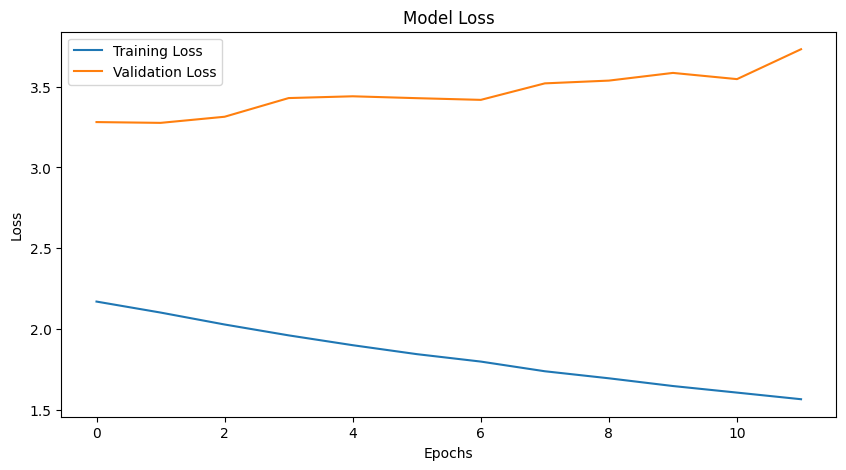

In [24]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Saving & Loading Model**

In [16]:
# Save the entire model to a file
model.save('Trained_Model.keras')
print("Model saved.")

Model saved.


In [17]:
# Load the model from the file
model = load_model('Trained_Model.keras')
print("Model loaded.")

Model loaded.


**Generating Music**

In [18]:
def generate_music(model, seed_sequence, n_notes_to_generate):
    generated_notes = []
    current_sequence = seed_sequence

    for _ in range(n_notes_to_generate):
        # Predict the next note
        prediction = model.predict(current_sequence, verbose=0)
        next_note = np.argmax(prediction, axis=1)[-1]

        # Append the predicted note to the genera22222222ted notes
        generated_notes.append(next_note)

        # Update the current sequence by appending the predicted note and removing the first note
        current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(next_note, (1, 1, -1)), axis=1)

    return generated_notes

# Seed sequence (example, use actual seed sequence from your dataset)
seed_sequence = X[0:1]

# Generate music
n_notes_to_generate = 100  # Number of notes to generate
generated_notes = generate_music(model, seed_sequence, n_notes_to_generate)

In [22]:
def notes_to_midi(generated_notes, output_midi_file):
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)

    for note in generated_notes:
        # Note on event
        track.append(Message('note_on', note=int(note), velocity=64, time=0))
        # Note off event after a fixed time
        track.append(Message('note_off', note=int(note), velocity=64, time=480))

    midi.save(output_midi_file)
    print(f'Generated MIDI file saved as {output_midi_file}')

# Specify the full path where you want to save the MIDI file
output_midi_file = 'Generated.mid'

# Convert to MIDI and save
notes_to_midi(generated_notes, output_midi_file)

Generated MIDI file saved as Generated.mid
